# Описание проекта

Аналитику крупного интернет-магазина поставлена задача. Вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

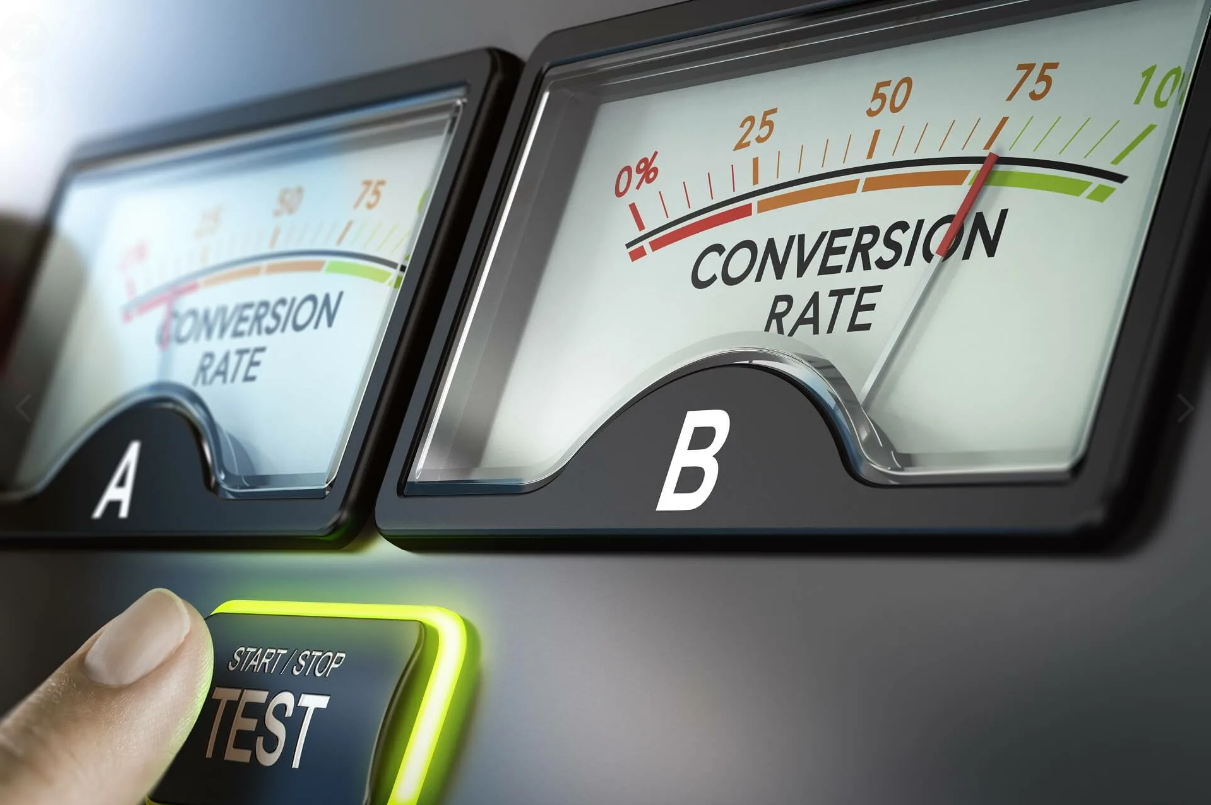

In [210]:
# загружаем необходимые библиотеки

import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

In [211]:
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [212]:
# загружаем датасеты

try:
    visitors = pd.read_csv('C:/Users/Admin/Documents/Data_Analytic/Datasets/visitors.csv')
    orders = pd.read_csv('C:/Users/Admin/Documents/Data_Analytic/Datasets/orders.csv')
    hypothesis = pd.read_csv('C:/Users/Admin/Documents/Data_Analytic/Datasets/hypothesis.csv')
except:
    visitors = pd.read_csv('/datasets/visitors.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [213]:
# изучим структуру датесетов

for i in [visitors, orders, hypothesis]:
    display(i.head(5))
    display(i.info())
    print('Количество дубликатов:', i.duplicated().sum())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Количество дубликатов: 0


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Количество дубликатов: 0


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

Количество дубликатов: 0


In [214]:
# приведем названия колонок к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

# приведем названия колонок к "змеиному" регистру
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}) 

In [215]:
# задаем ширину отображения столбца

pd.options.display.max_colwidth = 150

#### Описание данных

Файл **/datasets/visitors.csv**

*date* — дата;

*group* — группа A/B-теста;

*visitors* — количество пользователей в указанную дату в указанной группе A/B-теста.

Файл **/datasets/orders.csv**

*transactionId* — идентификатор заказа;

*visitorId* — идентификатор пользователя, совершившего заказ;

*date* — дата, когда был совершён заказ;

*revenue* — выручка заказа;

*group* — группа A/B-теста, в которую попал заказ.

Файл **/datasets/hypothesis.csv**

*Hypothesis* — краткое описание гипотезы;

*Reach* — охват пользователей по 10-балльной шкале;

*Impact* — влияние на пользователей по 10-балльной шкале;

*Confidence* — уверенность в гипотезе по 10-балльной шкале;

*Efforts* — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

## Часть 1. Приоритизация гипотез

Отдел маркетинга сформулировал гипотезы и изучил ожидаемые метрики. Проведем приоритизацию сформулированных гипотез, для этого изучим файл с гипотезами и оценками параметров **ICE** (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач.

In [216]:
# применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета

hypothesis['ICE'] = (
    hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
)

new_data = hypothesis.sort_values(by='ICE', ascending=False)

new_data[['hypothesis', 'ICE']]

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


**Вывод:** Гипотезы соответствующие свойствам важность и срочность - 9, 1, 8

Метод **RICE** является модификацией предыдущего метода и включает параметр Reach — скольких пользователей затронет изменение, которое мы хотим внести

In [217]:
# применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета

hypothesis['RICE'] = (
    (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
)

new_data = hypothesis.sort_values(by='RICE', ascending=False)

new_data[['hypothesis', 'RICE']]

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Вывод:** Метод присвоил гипотезе 8 первое место, хотя предыдущий метод показа лишь третье, это связано с тем, что значение охвата у гипотезы самое большое. На втором месте 3 гипотеза и 1 гипотеза на третьем.

## Часть 2. Анализ A/B-теста

Изучим графики кумулятивных, или накапливаемых данных. Наш тест шёл 31 день. 

### 2.1 Построим график кумулятивной выручки по группам

In [218]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max', 
            'group' : 'max', 
            'transaction_id' : 'nunique', 
            'visitor_id' : 'nunique', 
            'revenue' : 'sum'
        }
    ), 
    axis=1,
).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max', 
            'group' : 'max', 
            'visitors' : 'sum'
        }
    ), 
    axis=1,
).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date', 
    'group', 
    'orders', 
    'buyers', 
    'revenue', 
    'visitors'
]

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


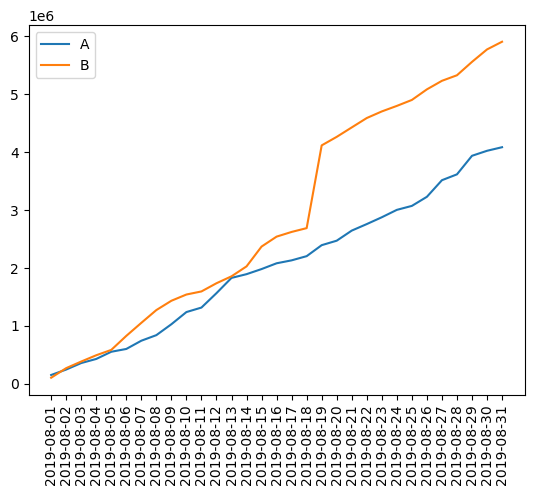

In [219]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=90)
plt.legend();

**Вывод:** Выручка в группе В была выше на протяжении всего теста. Но 18 августа значение выручки резко выросло и росло до конца наблюдения. Это означает аномальные значения выручки группы В в этот день, необходимо учесть в дальнейшем анализе.

### 2.2 Построим график кумулятивного среднего чека по группам

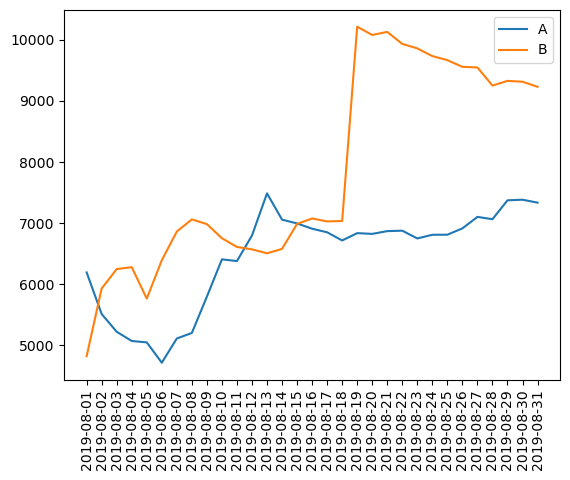

In [220]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=90)
plt.legend();

**Вывод:** Кумулятивное значение среднего чека в группе В резко изменилось 18 числа и затем снижалось до конца наблюдения. Средний чек в группе А снижался в начале наблюдения, затем резко вырос и до конца наблюдения находился в диапазоне 7000. Нужно больше данных, чтобы получить равномерный средний чек, принимать решение по этой метрике рано.

### 2.3 Построим график относительного изменения кумулятивного среднего чека группы B к группе A

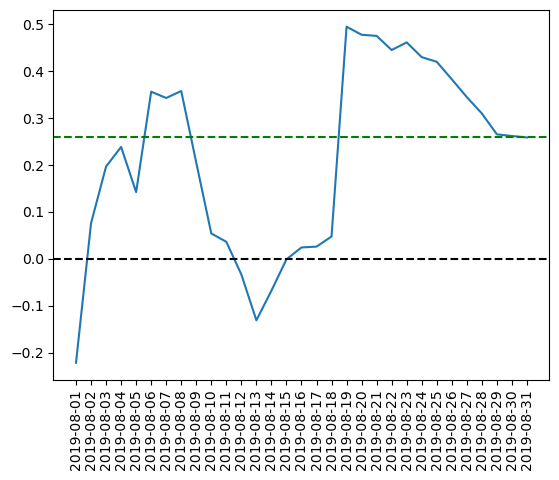

In [221]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation=90)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.26, color='green', linestyle='--');

**Вывод:** Результаты подтвердились, значения резко менялись в начале наблюдения и 18 числа. Видимо, именно тогда были совершены аномальные заказы. Относительного изменения кумулятивного среднего чека группы B к группе A значительно выше - 26%

### 2.4 Построим график кумулятивного среднего количества заказов на посетителя по группам

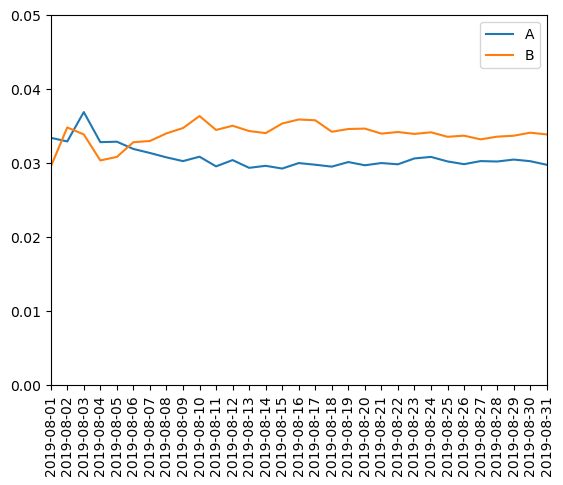

In [222]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.xticks(rotation=90)
plt.legend()
plt.axis(["2019-08-01", '2019-08-31', 0, 0.05]);

**Вывод:** В первые дни наблюдений значение среднего количества заказов в группах сильно колебались, затем значение группы В выросло и находилось в среднем около 3,4%. Значение группы А снизилось до 3% и оставалось на этом уровне до конца наблюдения.

### 2.5 Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

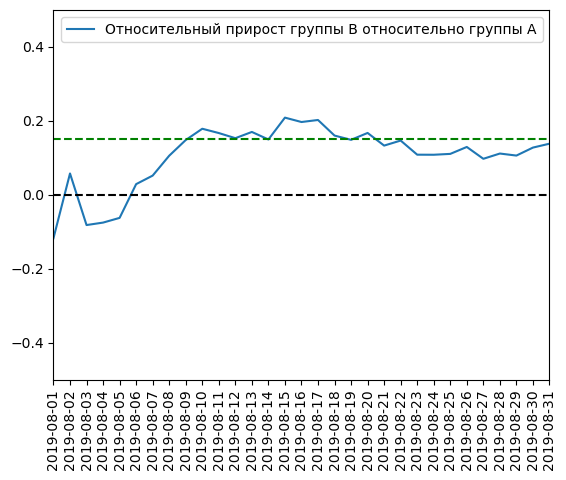

In [223]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['A', 'B']
)

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
         label="Относительный прирост группы B относительно группы A"
        )
plt.xticks(rotation=90)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='green', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.5, 0.5]);

**Вывод:** Группа В лидирует по кумулятивному среднему количеству заказов, прирост относительно группы А составил порядка 15%, на графике видно большинство точек находится на этом уровне.

### 2.6 Построим точечный график количества заказов по пользователям

      visitor_id  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


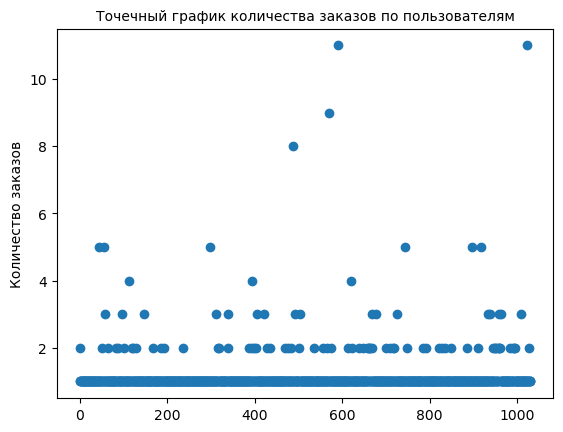

In [224]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям', fontsize=10)
plt.ylabel('Количество заказов', fontsize=10)
plt.show();

**Вывод:** Построили таблицу с уникальными пользователями совершивших максимальное количество заказов. На точечном графике пользователи редко совершают больше 2 заказов

### 2.7 Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберим границу для определения аномальных пользователей.

In [225]:
# Метод np.percentile('column', [percentile1, percentile2]) находит перцентили.

np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

**Вывод:** Действительно, не более 5% покупателей совершали больше двух заказов, а больше четырех заказов совершали не более 1% пользователей. Выберем границу аномальных пользователей - совершившие больше двух заказов будем считать аномальными.

### 2.8 Построим точечный график стоимостей заказов

      visitor_id  revenue
463   1920142716  1294500
503   2108080724   202740
1023  4256040402   176490
1026  4266935830   157980
569   2378935119   142939
316   1316129916    94770
314   1307669133    92550
213    888512513    86620
744   3062433592    75459
186    759473111    72000


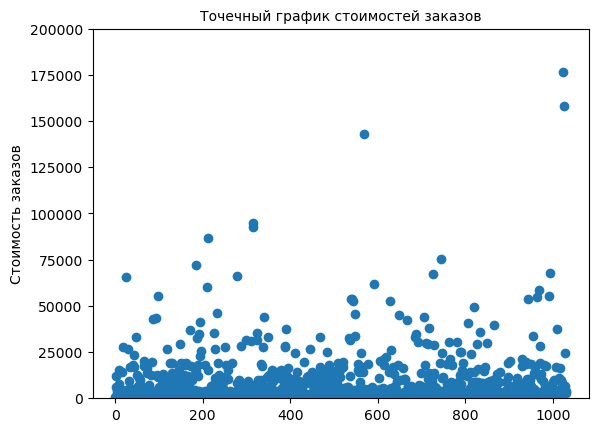

In [226]:
revenueByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'revenue': 'sum'})
)
revenueByUsers.columns = ['visitor_id', 'revenue']

print(revenueByUsers.sort_values(by='revenue', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в revenueByUsers
x_values = pd.Series(range(0, len(revenueByUsers)))

plt.scatter(x_values, revenueByUsers['revenue'])
plt.ylim(0, 200000)
plt.title('Точечный график стоимостей заказов', fontsize=10)
plt.ylabel('Стоимость заказов', fontsize=10)
plt.show();

**Вывод:** Из графика можно сделать вывод - основная доля заказов находится в диапазоне до 25000, для более точно определения границ стоимостей заказов, посчитаем перцентили.

### 2.9 Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберим границу для определения аномальных заказов

In [227]:
# Метод np.percentile('column', [percentile1, percentile2]) находит перцентили.

np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Вывод:** В предыдущем выводе почти верно определили границу заказов, не более 5% заказов имет стоимость выше 28000, и
 не более 1% заказов имеют стоимость выше 58233. Определим нижнюю границу аномальных заказов 28000

### 2.10 Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей. 

Сформулируем гипотезы.

Нулевая **(H0)**: различий в среднем количестве заказов между группами нет. 

Альтернативная **(H1)**: различия в среднем между группами есть

In [228]:
# Начнём с подготовки данных

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Названия столбцов данных:

*date* — дата;

*ordersPerDateA* — количество заказов в выбранную дату в группе A;

*revenuePerDateA* — суммарная выручка в выбранную дату в группе A;

*ordersPerDateB* — количество заказов в выбранную дату в группе B;

*revenuePerDateB* — суммарная выручка в выбранную дату в группе B;

*ordersCummulativeA* — суммарное число заказов до выбранной даты включительно в группе A;

*revenueCummulativeA* — суммарная выручка до выбранной даты включительно в группе A;

*ordersCummulativeB* — суммарное количество заказов до выбранной даты включительно в группе B;

*revenueCummulativeB* — суммарная выручка до выбранной даты включительно в группе B;

*visitorsPerDateA* — количество пользователей в выбранную дату в группе A;

*visitorsPerDateB* — количество пользователей в выбранную дату в группе B;

*visitorsCummulativeA* — количество пользователей до выбранной даты включительно в группе A;

*visitorsCummulativeB* — количество пользователей до выбранной даты включительно в группе B.

##### Посчитаем статистическую значимость различия в среднем количестве заказов между группами

In [229]:
# создадим переменныe ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders'], где для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов.

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders'] 

pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')

[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]

# объявим переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# посчитаем статистическую значимость различия среднего количества заказов по результатам двух недель теста. Применим тест Манна-Уитни. 

print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.01679
0.138


**Вывод:** p-value меньше 0.05, нулевую гипотезу **(H0)** отвергаем. Анализ "сырых данных" сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к конверсии группы А равен 13.8%

### 2.11 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем гипотезы.

Нулевая **(H0)**: различий в среднем чеке между группами нет. 

Альтернативная **(H1)**: различия в среднем чеке между группами есть

In [230]:
# Посчитаем статистическую значимость различия средних чеков между группами.

print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


**Вывод:** p-value больше 0.05 - нулевую гипотезу **(H0)** не отвергаем, отличий в среднем чеке между группами нет. Относительное значение среднего чека группы В больше на 26% чем в группе А.

### 2.12 Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Напомним, что 95-й и 99-й перцентили средних чеков равны 28 000 и 58 233 рублям. А 95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя. 
Примем за аномальных пользователей тех, кто совершил 3 заказа и более, или совершил заказ на сумму свыше 28 000 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% до 5% заказов с наибольшей стоимостью.
Удалять нужно именно пользователей — сначала определим аномальные заказы. Затем пользователей, совершивших их, и добавим их в список аномальных.

In [231]:
# сделаем срезы пользователей

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] >= 3]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] >= 3]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('Аномальные пользователи:', abnormalUsers.shape[0])

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitor_id, dtype: int64
Аномальные пользователи: 74


**Вывод:** Выявили аномальных пользователей, после их удаления посчитаем статистическую значимость. Выясним, есть ли существенные различия между группами с очищенными данными.

Сформулируем гипотезы.

Нулевая **(H0)**: различий в среднем количестве заказов между группами нет. 

Альтернативная **(H1)**: есть различия в среднем количестве заказов между группами

In [232]:
#cоздадим переменные sampleAFiltered и sampleBFiltered, в которых сохраним очищенные данные о заказах — не включая
#аномальных пользователей

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.01304
0.173


**Вывод:** Как и в случае с сырыми данными, статистическая значимость достигнута. Сегмент В значительно лучше сегмента А - нулевую гипотезу **(Н0)** отвергаем.

### 2.13 Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

Сформулируем гипотезы.

Нулевая **(H0)**: различий в среднем чеке между группами нет. 

Альтернативная **(H1)**: есть различия в среднем чеке между группами

In [233]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.738
-0.020


**Вывод:** p-value выше значения 0.05 нулевую гипотезу **(Н0)** не отвергаем, нет различий в среднем чеке между группами. Однако различие по средним значениям между "сырыми" данными стало статистически значимым, 0.259 против 0.02

### 2.14 Общий вывод
- Завершили исследование, приоритизировали гипотезы, запустили А/B тест, проанализировали результаты. В начале исследования предобработали данные, привели названия столбцов к единому стандарту.
- Приоритезировали гипотезы с помощью фреймворков ICE и RICE. Определили потенциальные гипотезы, соответствующие критериям срочности и важности:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

- В ходе проведения А/В тестов были получены следующие промежуточные выводы:
1. Кумулятивная выручка и значение кумулятивного среднего чека была выше у группы В
2. Относительное изменение кумулятивного среднего чека группы B к группе A выше на 26%
3. Кумулятивное среднее количество заказов на посетителя в группе В выше и составляет 3,4% в группе А - 3%
4. Группа В лидирует по кумулятивному среднему количеству заказов, прирост относительно группы А составил порядка 15%. График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.
5. Выбрали границы для определения аномальных пользователей, те которые совершили не более 2 заказов на сумму не превышающую 28000
6. Анализ статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» и "очищенным" данным сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к группе А равен 13.8% по "сырым" данным и 17.3% по "очищенным"
7. Нет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным и "очищенным" данным. Относительное значение среднего чека группы В больше на 26% чем в группе А

- Исходя из фактов выше, следует остановить тест, признать его успешным, группа B статистически значимо лучше группы A и перейти к проверке следующей гипотезы